In [2]:
import pandas as pd
import torch
import os
import numpy as np
import torch.nn.functional as F
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateFinder, BatchSizeFinder, EarlyStopping


from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    f1_score,             
    recall_score,         
    classification_report 
)
from scipy.stats import gmean

In [3]:
# cassava_df = pd.read_csv('/home/alumno/Desktop/datos/Computer Vision/cassava/cassava_split.csv')
cassava_df = pd.read_csv('/home/alumno/Desktop/datos/cassava/cassava_split.csv')

In [4]:
IMAGE_ROOT_DIR = '/home/alumno/Desktop/datos/cassava/images/'

In [5]:
#Hay que tener dos compose uno para training y otro para test

        # self.transform = transforms.Compose([
        #      transforms.Resize(256),#, interpolation=InterpolationMode.BILINEAR),              
        #      transforms.CenterCrop(224),
        #     ### Aquí es donde metemos el data augmentation
        #      transforms.ToTensor(),
        #      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
        # ])

In [6]:
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import lightning.pytorch as pl
from torchvision import transforms 
import lightning.pytorch as pl
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

# --- 1. CLASE CASSAVADATASET ---
class CassavaDataset(Dataset):
    """
    Dataset personalizado para el conjunto de datos de Cassava.
    """
    def __init__(self, df: pd.DataFrame, root_dir: str, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row['image_id']
        label = int(row['label']) 
        
        img_path = os.path.join(self.root_dir, img_name)
        # Cargamos la imagen y aseguramos el formato RGB
        image = Image.open(img_path).convert('RGB') 
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long)

class CassavaDataModule(pl.LightningDataModule):
    def __init__(self, data_df: pd.DataFrame, image_dir: str, batch_size: int = 64):
        super().__init__()
        
        self.data_df = data_df
        self.image_dir = image_dir
        self.batch_size = batch_size
        
        # Now we transform to match the data the model was originally trained on
        self.transform = transforms.Compose([
             transforms.Resize(256),#, interpolation=InterpolationMode.BILINEAR),              
             transforms.CenterCrop(224),          
             transforms.ToTensor(),
             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
        ])


        
        

    def setup(self, stage: str):
        # 1. Filtrar el DataFrame basado en la columna 'set'
        train_df = self.data_df[self.data_df['set'] == 'train'].reset_index(drop=True)
        val_df = self.data_df[self.data_df['set'] == 'val'].reset_index(drop=True)
        test_df = self.data_df[self.data_df['set'] == 'test'].reset_index(drop=True)
        
        # 2. Creación de los objetos Dataset
        self.train_ds = CassavaDataset(train_df, self.image_dir, transform=self.transform)
        self.val_ds = CassavaDataset(val_df, self.image_dir, transform=self.transform)
        self.test_ds = CassavaDataset(test_df, self.image_dir, transform=self.transform)

        print(f"Dataset sizes: Train={len(self.train_ds)}, Val={len(self.val_ds)}, Test={len(self.test_ds)}")

    # Métodos para crear los DataLoaders
    def train_dataloader(self):
        # Extract labels from the dataset dataframe
        labels = self.train_ds.df['label'].values
    
        # Compute class frequencies
        class_sample_count = np.array([len(np.where(labels == t)[0]) for t in np.unique(labels)])
        # Inverse of frequency as weights
        weights = 1. / class_sample_count
        # Assign weight to each sample
        samples_weight = np.array([weights[t] for t in labels])
    
        # Define sampler
        sampler = WeightedRandomSampler(
            weights=torch.DoubleTensor(samples_weight),
            num_samples=len(samples_weight),
            replacement=True
        )
    
        return DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            sampler=sampler,
            num_workers=2
        )

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size, shuffle=False, num_workers = 4)

    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.batch_size, shuffle=False, num_workers = 4)

In [7]:
class LightningModule(pl.LightningModule):
    def __init__(self, model, lr=1e-3, wd=0., discriminative_lr=None):
        super().__init__()
        self.model = model
        self.lr = lr
        self.wd = wd
        self.discriminative_lr = discriminative_lr # (lr, lr_mult)

        self.training_step_outputs = defaultdict(float)
        self.validation_step_outputs = defaultdict(float)

    def get_layer_wise_lr(self, lr, lr_mult):

        # Save layer names
        layer_names = []
        for idx, (name, param) in enumerate(self.model.named_parameters()):
            layer_names.append(name)
            print(f'{idx}: {name}')
        
        # Reverse layers
        layer_names.reverse()
        
        # placeholder
        parameters      = []
        prev_group_name = layer_names[0].split('.')[0]
        
        # store params & learning rates
        for idx, name in enumerate(layer_names):
            
            # parameter group name
            cur_group_name = name.split('.')[0]
            
            # update learning rate
            if cur_group_name != prev_group_name:
                lr *= lr_mult
            prev_group_name = cur_group_name
            
            # display info
            print('Using discriminative learning rates')
            print(f'{idx}: lr = {lr:.6f}, {name}')
            
            # append layer parameters
            parameters += [{'params': [p for n, p in model.named_parameters() if n == name and p.requires_grad],
                            'lr':     lr}]

        return parameters
        

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        
        return torch.optim.Adam(
            self.parameters() if self.discriminative_lr == None else self.get_layer_wise_lr(*self.discriminative_lr), 
            lr=self.lr, weight_decay=self.wd)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        
        self.training_step_outputs['loss'] += loss.detach().cpu()
        self.training_step_outputs['steps'] += 1
            
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True)

        self.validation_step_outputs['loss'] += loss.detach().cpu()
        self.validation_step_outputs['steps'] += 1
        
        return loss

    def on_train_epoch_end(self): 
        avg_loss = self.training_step_outputs['loss'] / self.training_step_outputs['steps']
        print(f"Average training loss for epoch {self.current_epoch}: {avg_loss.item():.4f}")
        self.training_step_outputs.clear() 

    def on_validation_epoch_end(self):
        avg_loss = self.validation_step_outputs['loss'] / self.validation_step_outputs['steps']
        print(f"Average validation loss for epoch {self.current_epoch}: {avg_loss.item():.4f}")
        self.validation_step_outputs.clear()

In [35]:

lr_finder = LearningRateFinder(
    min_lr=1e-6,
    max_lr=1e-2,
    num_training_steps=30,
    mode='exponential',
    early_stop_threshold=10.0
)


bs_finder = BatchSizeFinder(
    mode='power',
    steps_per_trial=2,
    init_val=16,
    max_trials=3
)



model_checkpoint = ModelCheckpoint(
    monitor='val_loss',
    mode='min',
    save_top_k=1,
    save_last=True,
    verbose=False
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=5,
    verbose=True,
    mode="min"
)


In [36]:
from torchvision import models
from torchvision.models import ResNet18_Weights
from torch import nn
from collections import defaultdict

pl.seed_everything(seed=42, workers=True)
data_module = CassavaDataModule(cassava_df, IMAGE_ROOT_DIR)
data_module.setup('fit')

ckpt_path = "/home/alumno/Desktop/datos/Assigment 2/assigment2/best_valid_loss.ckpt"

model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

num_in_feat = model.fc.in_features
model.fc = nn.Linear(num_in_feat, 5)

# Load the best model. Note that we need to include all the LightningMNISTClassifier's __init__ parameters
lightning_module = LightningModule.load_from_checkpoint(ckpt_path, model=model)
lightning_module.cuda(0) # Move to GPU

# Define a CSV logger to store training/validation metrics in CSV format.
csv_logger = CSVLogger(save_dir=os.getcwd(), name="cassava_resnet18_tl_ft_feature_extraction")

# Define a checkpoint callback:
# It will save the model with the lowest validation loss ("best_valid_loss.ckpt").
model_checkpoint_callback = pl.callbacks.model_checkpoint.ModelCheckpoint(
    monitor='val_loss',mode='min', filename='best_valid_loss', verbose=True, save_last=False)

# Create a PyTorch Lightning trainer
trainer = pl.Trainer(max_epochs=10, logger=csv_logger, callbacks=[model_checkpoint_callback, lr_finder, bs_finder]) #limit_train_batches=2 es para que me entrene

# Load the data module
data_module = CassavaDataModule(cassava_df, IMAGE_ROOT_DIR)

lightning_module.train()
# Train the model with the trainer, passing the core LightningModule and data module.
trainer.fit(lightning_module, data_module)

# # Move to GPU if needed
# lightning_module.eval()


Seed set to 42


INFO: No se proporcionó 'train_transform'. Usando transformaciones de validación para train.
Dataset sizes: Train=14977, Val=3210, Test=3210
Train Transforms: Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Val/Test Transforms: Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


INFO: No se proporcionó 'train_transform'. Usando transformaciones de validación para train.
Dataset sizes: Train=14977, Val=3210, Test=3210
Train Transforms: Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Val/Test Transforms: Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


Finding best initial lr:   0%|          | 0/30 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=30` reached.
Restoring states from the checkpoint path at /home/alumno/Desktop/datos/Assigment 2/assigment2/.lr_find_e34379d5-d492-4fb4-823d-5c2be56dbdab.ckpt
Restored all states from the checkpoint at /home/alumno/Desktop/datos/Assigment 2/assigment2/.lr_find_e34379d5-d492-4fb4-823d-5c2be56dbdab.ckpt


Average training loss for epoch 0: 1.8741


Learning rate set to 5.411695265464637e-05
`Trainer.fit` stopped: `max_steps=2` reached.
Batch size 16 succeeded, trying batch size 32


Average training loss for epoch 0: 1.7773


`Trainer.fit` stopped: `max_steps=2` reached.
Batch size 32 succeeded, trying batch size 64


Average training loss for epoch 0: 1.9010


`Trainer.fit` stopped: `max_steps=2` reached.
Batch size 64 succeeded, trying batch size 128


Average training loss for epoch 0: 0.4269


Finished batch size finder, will continue with full run using batch size 128
Restoring states from the checkpoint path at /home/alumno/Desktop/datos/Assigment 2/assigment2/.scale_batch_size_5ecc6574-49aa-4a42-a7f9-54b1361fc27c.ckpt
Restored all states from the checkpoint at /home/alumno/Desktop/datos/Assigment 2/assigment2/.scale_batch_size_5ecc6574-49aa-4a42-a7f9-54b1361fc27c.ckpt

  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | model | ResNet | 11.2 M | train
-----------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.716    Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode
Restored all states from the checkpoint at /home/alumno/Desktop/datos/Assigment 2/assigment2/.scale_batch_size_5ecc6574-49aa-4a42-a7f9-54b1361fc27c.ckpt


Sanity Checking: |                                                                                            …

Average validation loss for epoch 0: 0.7178


Training: |                                                                                                   …

Validation: |                                                                                                 …

Epoch 0, global step 118: 'val_loss' reached 0.68288 (best 0.68288), saving model to '/home/alumno/Desktop/datos/Assigment 2/assigment2/cassava_resnet18_tl_ft_feature_extraction/version_3/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 0: 0.6741
Average training loss for epoch 0: 0.6724


Validation: |                                                                                                 …

Epoch 1, global step 236: 'val_loss' was not in top 1


Average validation loss for epoch 1: 0.6703
Average training loss for epoch 1: 0.2168


Validation: |                                                                                                 …

Epoch 2, global step 354: 'val_loss' was not in top 1


Average validation loss for epoch 2: 0.6969
Average training loss for epoch 2: 0.1015


Validation: |                                                                                                 …

Epoch 3, global step 472: 'val_loss' was not in top 1


Average validation loss for epoch 3: 0.7154
Average training loss for epoch 3: 0.0552


Validation: |                                                                                                 …

Epoch 4, global step 590: 'val_loss' was not in top 1


Average validation loss for epoch 4: 0.7419
Average training loss for epoch 4: 0.0461


Validation: |                                                                                                 …

Epoch 5, global step 708: 'val_loss' was not in top 1


Average validation loss for epoch 5: 0.7819
Average training loss for epoch 5: 0.0530


Validation: |                                                                                                 …

Epoch 6, global step 826: 'val_loss' was not in top 1


Average validation loss for epoch 6: 0.8255
Average training loss for epoch 6: 0.0363


Validation: |                                                                                                 …

Epoch 7, global step 944: 'val_loss' was not in top 1


Average validation loss for epoch 7: 0.8374
Average training loss for epoch 7: 0.0182


Validation: |                                                                                                 …

Epoch 8, global step 1062: 'val_loss' was not in top 1


Average validation loss for epoch 8: 0.8061
Average training loss for epoch 8: 0.0277


Validation: |                                                                                                 …

Epoch 9, global step 1180: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


Average validation loss for epoch 9: 0.8230
Average training loss for epoch 9: 0.0259


In [45]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

class_names = {
    0: "Cassava Bacterial Blight (CBB)",
    1: "Cassava Brown Streak Disease (CBSD)",
    2: "Cassava Green Mottle (CGM)",
    3: "Cassava Mosaic Disease (CMD)",
    4: "Healthy"
}
y_trues, y_hats = [], []
# Asegúrate de que el modelo esté en modo evaluación
lightningModule_cargado.eval()
for (x, y_true) in iter(data_module.test_dataloader()):

    with torch.no_grad():
        y_hat_logits = lightningModule_cargado(x)
        y_hat = nn.Softmax(1)(y_hat_logits).argmax(1)
        y_hat = y_hat.detach().cpu()

    y_hats.append(y_hat)
    y_trues.append(y_true)

y_trues = torch.cat(y_trues)
y_hats = torch.cat(y_hats)

print(f'Acc.: {accuracy_score(y_trues, y_hats):.4f}')

# Lista de etiquetas para los cálculos (del 0 al 4)
labels_list = torch.arange(5)

# --- 1. F1 SCORE (Macro) ---
# 'macro' calcula la métrica para cada clase y saca la media (sin ponderar)
f1_macro_data_no_transf = f1_score(y_trues, y_hats, average='macro', labels=labels_list)
print(f'F1 Score (Macro): {f1_macro_data_no_transf:.4f}')

# --- 2. MEDIA GEOMÉTRICA (G-Mean) ---
# Primero, obtenemos el Recall (sensibilidad) para CADA clase por separado
per_class_recall__data_no_transf = recall_score(y_trues, y_hats, average=None, labels=labels_list)
print("\nRecall por clase (para G-Mean):")
print(per_class_recall)

# Calculamos la media geométrica: (R1 * R2 * ... * Rn)^(1/n)
# Nota: Si el recall de CUALQUIER clase es 0, la G-Mean será 0.
g_mean__data_no_transf = np.prod(per_class_recall)**(1.0 / len(per_class_recall))
print(f'Media Geométrica (G-Mean): {g_mean:.4f}\n')


# --- REPORTE DE CLASIFICACIÓN ---
# Esta función te da Recall, Precision y F1 por clase, todo de una vez.
class_labels_data_no_transf = list(class_names.values()) 
print("--- Reporte de Clasificación Detallado ---")
print(classification_report(y_trues, y_hats, target_names=class_labels_data_no_transf, labels=labels_list))


# --- Tu código de Matriz de Confusión ---
cm = confusion_matrix(y_trues, y_hats, labels=labels_list)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.savefig("Confusion_matrix_original", dpi=400)
plt.show()

Acc.: 0.8097
F1 Score (Macro): 0.6638

Recall por clase (para G-Mean):


NameError: name 'per_class_recall' is not defined

In [7]:
# from sklearn.metrics import roc_curve, auc
# from sklearn.preprocessing import label_binarize
# import matplotlib.pyplot as plt
# import torch.nn.functional as F
# import numpy as np

# # Assuming y_trues and y_probs are already collected as in your previous code
# n_classes = len(class_labels)

# # Binarize true labels
# y_true_onehot = F.one_hot(y_trues, num_classes=n_classes).numpy()
# y_probs_np = y_probs.numpy()

# # Plot ROC curves for each class
# plt.figure(figsize=(10, 8))
# for i in range(n_classes):
#     fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_probs_np[:, i])
#     roc_auc = auc(fpr, tpr)
#     plt.plot(fpr, tpr, lw=2, label=f'Class {class_labels[i]} (AUC = {roc_auc:.2f})')

# plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Multi-class ROC Curves')
# plt.legend(loc="lower right")
# plt.grid(True)
# plt.savefig("ROC_curves.png", dpi=400)
# plt.show()


NameError: name 'class_labels' is not defined

# Data Augmentation

## <span style="color:#D52B29">Geometric Transformations</span>

Ha dicho que primero inferamos en test saquemos y ploteemos las peores 10 imagenes que clasifica y de ahí pensemos los métodos que podamos agregarle para poder mejorar. 

TRANSFORMACIONES GEOMETRICAS
Pensamos que lo mejor puede ser dihedral y el zoom. 

TRANSFORMACIONES COLOR 
De las photometricas es brillo, contraste. SObre todo saturación con jitter y blurring sharpening. 

In [15]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from PIL import Image
import random

def visualize_transform_compare(dataset, transform, n=6):
    """
    Show original vs transformed images side by side for n random samples.
    """
    indices = random.sample(range(len(dataset)), n)
    
    fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(8, 4*n))
    
    for i, idx in enumerate(indices):
        img_path = os.path.join(dataset.root_dir, dataset.df.iloc[idx]['image_id'])
        img = Image.open(img_path).convert('RGB')
        
        transformed_img = transform(img)
        
        # Convert tensors to numpy
        if isinstance(transformed_img, torch.Tensor):
            transformed_img = transformed_img.permute(1, 2, 0).numpy()
            transformed_img = (transformed_img - transformed_img.min()) / (transformed_img.max() - transformed_img.min())
        
        img_np = np.array(img) / 255.0  # normalize original for plotting
        
        # Original
        axes[i, 0].imshow(img_np)
        axes[i, 0].set_title("Original")
        axes[i, 0].axis('off')
        
        # Transformed
        axes[i, 1].imshow(transformed_img)
        axes[i, 1].set_title(f"Transformed: {transform.__class__.__name__}")
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.savefig("
    plt.show()




train_df = cassava_df[cassava_df['set'] == 'train'].reset_index(drop=True)
temp_dataset = CassavaDataset(train_df, root_dir=IMAGE_ROOT_DIR)

# # Example: RandomResizedCrop
# single_transform = transforms.RandomResizedCrop(size=256, scale=(0.6, 1.0), ratio=(0.8, 1.2))
# visualize_transform_compare(temp_dataset, single_transform, n=6)

# # Example: ColorJitter
# single_transform = transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3)
# visualize_transform_compare(temp_dataset, single_transform, n=6)

# # Example: RandomHorizontalFlip
# single_transform = transforms.RandomHorizontalFlip(p=0.5)
# visualize_transform_compare(temp_dataset, single_transform, n=6)


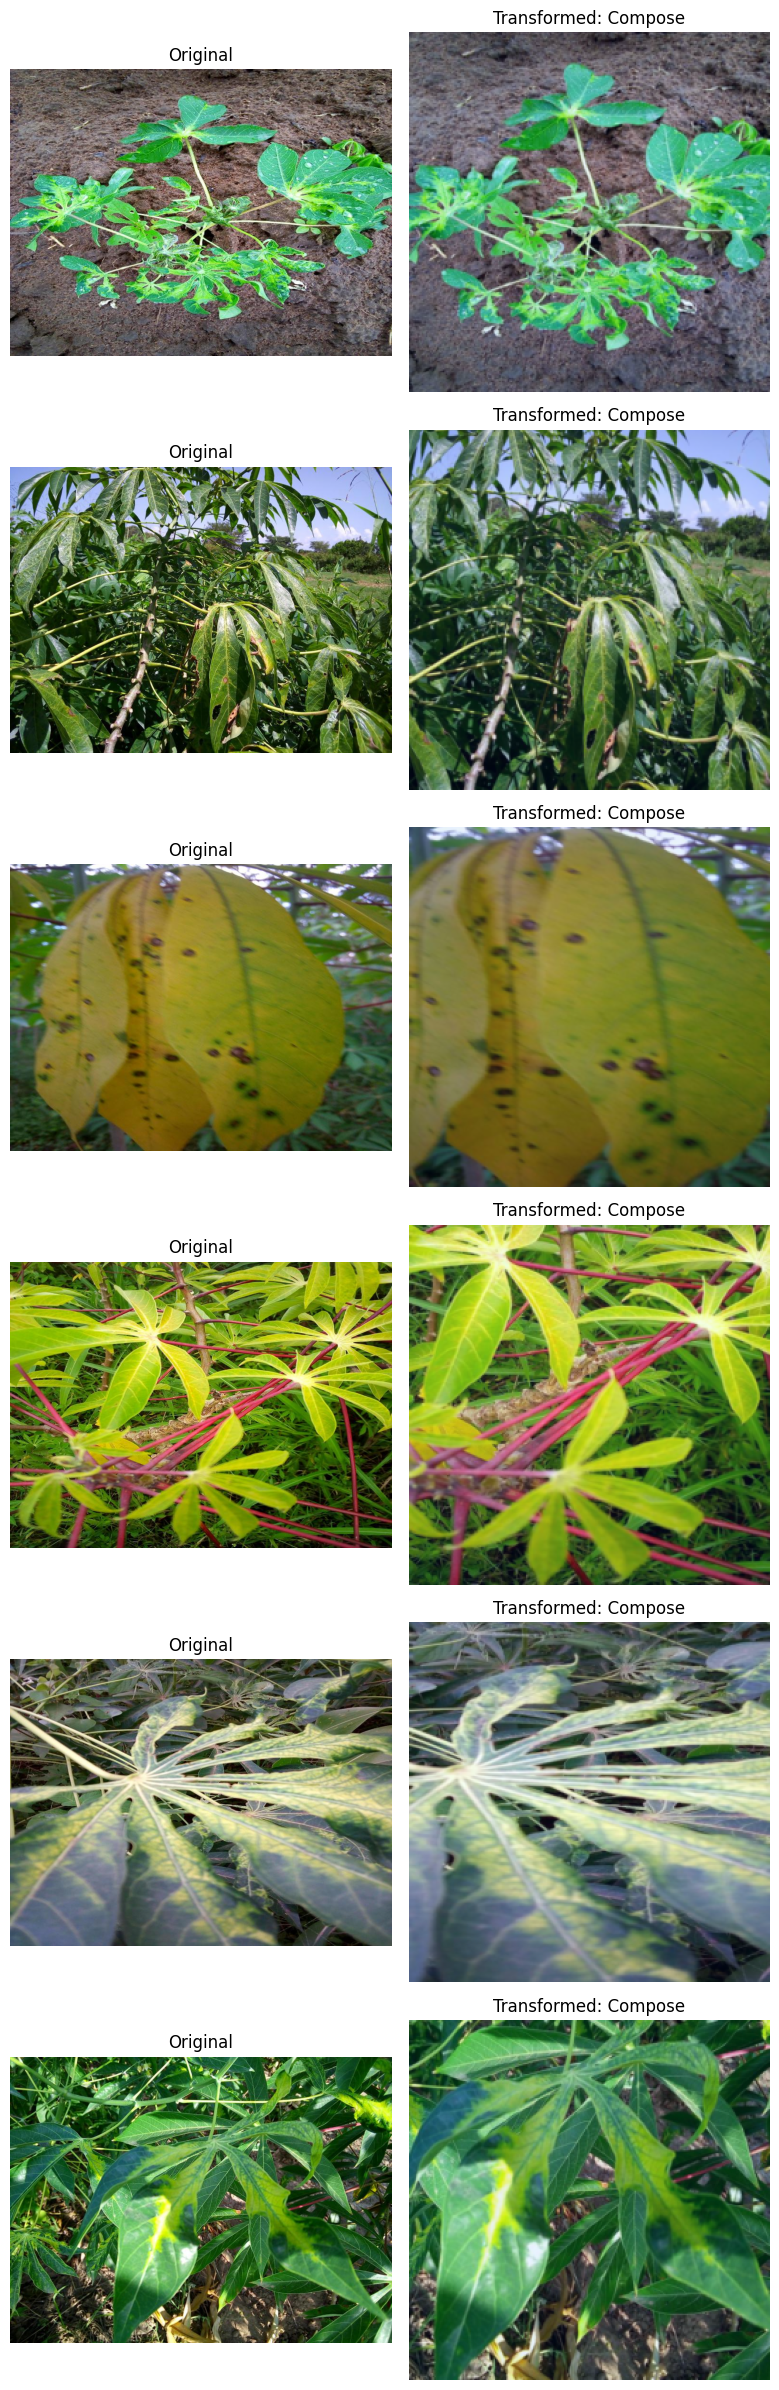

In [21]:
# transform_diheral =transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#         transforms.RandomHorizontalFlip(p=0.2),
#         transforms.RandomVerticalFlip(p=0.2),
#         transforms.RandomRotation(degrees=(90, 90))
#     ]) 
# visualize_transform_compare(temp_dataset, transform_diheral, n=6)

transform_RandomResizedCrop=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomResizedCrop(size=256, scale=(0.5, 1.0), ratio=((0.75, 1.33)))
    ]) 
visualize_transform_compare(temp_dataset, transform_RandomResizedCrop, n=6)

In [1]:
transform_diheral =transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        
    ]) 
# visualize_transform_compare(temp_dataset, transform_diheral, n=6)

transform_RandomResizedCrop=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomResizedCrop(size=256, scale=(0.5, 1.0), ratio=((0.75, 1.33)))
    ]) 




NameError: name 'transforms' is not defined

In [10]:
import torch.nn.functional as F
import pandas as pd
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import lightning.pytorch as pl

from PIL import Image, ImageFilter
from torchvision import models, transforms
from torchvision.models import ResNet18_Weights
from torch import nn
from collections import defaultdict
from torchvision.transforms import InterpolationMode
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler


from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateFinder, BatchSizeFinder, EarlyStopping


from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    f1_score,             
    recall_score,         
    classification_report 
)
from scipy.stats import gmean

In [2]:
# cassava_df = pd.read_csv('/home/alumno/Desktop/datos/Computer Vision/cassava/cassava_split.csv')
cassava_df = pd.read_csv('/home/alumno/Desktop/datos/cassava/cassava_split.csv')

In [3]:
IMAGE_ROOT_DIR = '/home/alumno/Desktop/datos/cassava/images/'

In [11]:
#  1. CLASE CASSAVADATASET 
class CassavaDataset(Dataset):
    """
    Dataset personalizado para el conjunto de datos de Cassava.
    """
    def __init__(self, df: pd.DataFrame, root_dir: str, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row['image_id']
        label = int(row['label']) 
        
        img_path = os.path.join(self.root_dir, img_name)
        # Cargamos la imagen y aseguramos el formato RGB
        image = Image.open(img_path).convert('RGB') 
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long)


In [12]:
class CassavaDataModule(pl.LightningDataModule):
    def __init__(self, data_df: pd.DataFrame, image_dir: str, batch_size: int = 64, train_transform=None): #  Renombrado para claridad
        
        super().__init__()
        self.data_df = data_df
        self.image_dir = image_dir
        self.batch_size = batch_size
        
        # 2: Lógica de transformaciones separada
        
        # 2.1. Define la transformación de validación y test (la que antes era 'por defecto')
        # Esta transformación NO lleva data augmentation.
        self.val_test_transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
        ])
        
        # 2.2. Asigna la transformación de entrenamiento
        if train_transform is None:
            # Si el usuario no pasa una 'train_transform', 
            # usamos la misma de validación (sin augmentation)
            self.train_transform = self.val_test_transform
            print("INFO: No se proporcionó 'train_transform'. Usando transformaciones de validación para train.")
        else:
            # Si el usuario SÍ pasa una 'train_transform', la usamos.
            self.train_transform = train_transform
            print("INFO: Usando 'train_transform' personalizada para el conjunto de entrenamiento.")


    def setup(self, stage: str = None): # <-- 'stage' puede ser None por defecto
        # 1. Filtrar el DataFrame basado en la columna 'set'
        train_df = self.data_df[self.data_df['set'] == 'train'].reset_index(drop=True)
        val_df = self.data_df[self.data_df['set'] == 'val'].reset_index(drop=True)
        test_df = self.data_df[self.data_df['set'] == 'test'].reset_index(drop=True)
        
        # Asignar las transformaciones correctas a cada Dataset 
        self.train_ds = CassavaDataset(train_df, self.image_dir, 
                                       transform=self.train_transform) # <-- Transformación de TRAIN
        
        self.val_ds = CassavaDataset(val_df, self.image_dir, 
                                     transform=self.val_test_transform) # <-- Transformación de VAL/TEST
        
        self.test_ds = CassavaDataset(test_df, self.image_dir, 
                                      transform=self.val_test_transform) # <-- Transformación de VAL/TEST

        print(f"Dataset sizes: Train={len(self.train_ds)}, Val={len(self.val_ds)}, Test={len(self.test_ds)}")
        print(f"Train Transforms: {self.train_transform}")
        print(f"Val/Test Transforms: {self.val_test_transform}")

    #  Métodos Dataloader  
    def train_dataloader(self):
        labels = self.train_ds.df['label'].values
        class_sample_count = np.array([len(np.where(labels == t)[0]) for t in np.unique(labels)])
        weights = 1. / class_sample_count
        samples_weight = np.array([weights[t] for t in labels])
        sampler = WeightedRandomSampler(
            weights=torch.DoubleTensor(samples_weight),
            num_samples=len(samples_weight),
            replacement=True
        )
        return DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            sampler=sampler,
            num_workers=4
        )

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size, shuffle=False, num_workers = 4)

    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.batch_size, shuffle=False, num_workers = 4)

In [13]:
class LightningModule(pl.LightningModule):
    def __init__(self, model, lr=1e-3, wd=0., discriminative_lr=None):
        super().__init__()
        self.model = model
        self.lr = lr
        self.wd = wd
        self.discriminative_lr = discriminative_lr # (lr, lr_mult)

        self.training_step_outputs = defaultdict(float)
        self.validation_step_outputs = defaultdict(float)

    def get_layer_wise_lr(self, lr, lr_mult):

        # Save layer names
        layer_names = []
        for idx, (name, param) in enumerate(self.model.named_parameters()):
            layer_names.append(name)
            print(f'{idx}: {name}')
        
        # Reverse layers
        layer_names.reverse()
        
        # placeholder
        parameters      = []
        prev_group_name = layer_names[0].split('.')[0]
        
        # store params & learning rates
        for idx, name in enumerate(layer_names):
            
            # parameter group name
            cur_group_name = name.split('.')[0]
            
            # update learning rate
            if cur_group_name != prev_group_name:
                lr *= lr_mult
            prev_group_name = cur_group_name
            
            # display info
            print('Using discriminative learning rates')
            print(f'{idx}: lr = {lr:.6f}, {name}')
            
            # append layer parameters
            parameters += [{'params': [p for n, p in model.named_parameters() if n == name and p.requires_grad],
                            'lr':     lr}]

        return parameters
        

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        
        return torch.optim.Adam(
            self.parameters() if self.discriminative_lr == None else self.get_layer_wise_lr(*self.discriminative_lr), 
            lr=self.lr, weight_decay=self.wd)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        
        self.training_step_outputs['loss'] += loss.detach().cpu()
        self.training_step_outputs['steps'] += 1
            
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True)

        self.validation_step_outputs['loss'] += loss.detach().cpu()
        self.validation_step_outputs['steps'] += 1
        
        return loss

    def on_train_epoch_end(self): 
        avg_loss = self.training_step_outputs['loss'] / self.training_step_outputs['steps']
        print(f"Average training loss for epoch {self.current_epoch}: {avg_loss.item():.4f}")
        self.training_step_outputs.clear() 

    def on_validation_epoch_end(self):
        avg_loss = self.validation_step_outputs['loss'] / self.validation_step_outputs['steps']
        print(f"Average validation loss for epoch {self.current_epoch}: {avg_loss.item():.4f}")
        self.validation_step_outputs.clear()

In [14]:

lr_finder = LearningRateFinder(
    min_lr=1e-6,
    max_lr=1e-2,
    num_training_steps=30,
    mode='exponential',
    early_stop_threshold=10.0
)


bs_finder = BatchSizeFinder(
    mode='power',
    steps_per_trial=2,
    init_val=16,
    max_trials=3
)



model_checkpoint = ModelCheckpoint(
    monitor='val_loss',
    mode='min',
    save_top_k=1,
    save_last=True,
    verbose=False
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=5,
    verbose=True,
    mode="min"
)


Iniciamos la prueba con solo **transformaciones geometricas**

In [15]:
# Set random seed for reproducibility
pl.seed_everything(seed=42, workers=True)

transformacion_Geometrica = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomVerticalFlip(p=0.4),
    transforms.RandomRotation(degrees=(90, 90)),
    # transforms.RandomResizedCrop(size=256, scale=(0.5, 1.0), ratio=((0.75, 1.33))),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

data_module = CassavaDataModule(cassava_df, IMAGE_ROOT_DIR)
data_module.setup('fit')

ckpt_path = "/home/alumno/Desktop/datos/Assigment 2/assigment2/best_valid_loss.ckpt"

base_model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

num_in_feat = base_model.fc.in_features
base_model.fc = nn.Linear(num_in_feat, 5)

# Load the best model. Note that we need to include all the LightningMNISTClassifier's __init__ parameters
# model = LightningModule.load_from_checkpoint(ckpt_path, model=model)

# Como sabemos que el 
lightningModule_cargado = LightningModule.load_from_checkpoint(
    ckpt_path, 
    model=base_model 
)


# Define a CSV logger to store training/validation metrics in CSV format.
csv_logger = CSVLogger(save_dir=os.getcwd(), name="cassava_resnet18_tl_ft_feature_Extractor")

# Define a checkpoint callback:
# It will save the model with the lowest validation loss ("best_valid_loss.ckpt").
model_checkpoint_callback = pl.callbacks.model_checkpoint.ModelCheckpoint(
    monitor='val_loss',mode='min', filename='best_valid_loss', verbose=True, save_last=False)

# Create a PyTorch Lightning trainer
trainer = pl.Trainer(max_epochs=10, logger=csv_logger, callbacks=[model_checkpoint_callback, lr_finder, bs_finder],accelerator='gpu') 
# Load the data module
data_module_trans_geo = CassavaDataModule(cassava_df, IMAGE_ROOT_DIR, train_transform = transformacion_Geometrica)

lightningModule_cargado.train()
# Train the lightningModule_cargado with the trainer, passing the core LightningModule and data module.
trainer.fit(lightningModule_cargado, data_module_trans_geo)

# # Move to GPU if needed
# lightningModule_cargado.eval()



Seed set to 42


INFO: No se proporcionó 'train_transform'. Usando transformaciones de validación para train.
Dataset sizes: Train=14977, Val=3210, Test=3210
Train Transforms: Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Val/Test Transforms: Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


INFO: Usando 'train_transform' personalizada para el conjunto de entrenamiento.
Dataset sizes: Train=14977, Val=3210, Test=3210
Train Transforms: Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    RandomHorizontalFlip(p=0.4)
    RandomVerticalFlip(p=0.4)
    RandomRotation(degrees=[90.0, 90.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Val/Test Transforms: Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


Finding best initial lr:   0%|          | 0/30 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=30` reached.
Restoring states from the checkpoint path at /home/alumno/Desktop/datos/Assigment 2/assigment2/.lr_find_80335fd5-7f6e-4374-ae4d-980e8fac4274.ckpt
Restored all states from the checkpoint at /home/alumno/Desktop/datos/Assigment 2/assigment2/.lr_find_80335fd5-7f6e-4374-ae4d-980e8fac4274.ckpt


Average training loss for epoch 0: 2.0565


Learning rate set to 5.411695265464637e-05
`Trainer.fit` stopped: `max_steps=2` reached.
Batch size 16 succeeded, trying batch size 32


Average training loss for epoch 0: 2.0650


`Trainer.fit` stopped: `max_steps=2` reached.
Batch size 32 succeeded, trying batch size 64


Average training loss for epoch 0: 2.1660


`Trainer.fit` stopped: `max_steps=2` reached.
Batch size 64 succeeded, trying batch size 128


Average training loss for epoch 0: 0.5041


Finished batch size finder, will continue with full run using batch size 128
Restoring states from the checkpoint path at /home/alumno/Desktop/datos/Assigment 2/assigment2/.scale_batch_size_61b43406-7e7c-45dc-89a1-3850393b359d.ckpt
Restored all states from the checkpoint at /home/alumno/Desktop/datos/Assigment 2/assigment2/.scale_batch_size_61b43406-7e7c-45dc-89a1-3850393b359d.ckpt

  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | model | ResNet | 11.2 M | train
-----------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.716    Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode
Restored all states from the checkpoint at /home/alumno/Desktop/datos/Assigment 2/assigment2/.scale_batch_size_61b43406-7e7c-45dc-89a1-3850393b359d.ckpt


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Average validation loss for epoch 0: 0.7178


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 0, global step 118: 'val_loss' reached 0.95747 (best 0.95747), saving model to '/home/alumno/Desktop/datos/Assigment 2/assigment2/cassava_resnet18_tl_ft_feature_Extractor/version_9/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 0: 0.9474
Average training loss for epoch 0: 0.8969


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 1, global step 236: 'val_loss' reached 0.92478 (best 0.92478), saving model to '/home/alumno/Desktop/datos/Assigment 2/assigment2/cassava_resnet18_tl_ft_feature_Extractor/version_9/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 1: 0.9077
Average training loss for epoch 1: 0.5383


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 2, global step 354: 'val_loss' reached 0.81293 (best 0.81293), saving model to '/home/alumno/Desktop/datos/Assigment 2/assigment2/cassava_resnet18_tl_ft_feature_Extractor/version_9/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 2: 0.8040
Average training loss for epoch 2: 0.3953


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 3, global step 472: 'val_loss' was not in top 1


Average validation loss for epoch 3: 0.9198
Average training loss for epoch 3: 0.2889


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 4, global step 590: 'val_loss' was not in top 1


Average validation loss for epoch 4: 0.9025
Average training loss for epoch 4: 0.2226


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 5, global step 708: 'val_loss' was not in top 1


Average validation loss for epoch 5: 0.9705
Average training loss for epoch 5: 0.1924


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 6, global step 826: 'val_loss' was not in top 1


Average validation loss for epoch 6: 1.0338
Average training loss for epoch 6: 0.1406


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 7, global step 944: 'val_loss' was not in top 1


Average validation loss for epoch 7: 1.1034
Average training loss for epoch 7: 0.1074


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 8, global step 1062: 'val_loss' was not in top 1


Average validation loss for epoch 8: 1.0242
Average training loss for epoch 8: 0.0921


Validation: |                                                                                                 …

Epoch 9, global step 1180: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


Average validation loss for epoch 9: 0.9496
Average training loss for epoch 9: 0.0861


INtentamos poner el lr que ha encontrado el lr finder para así no tener que calcularlo todo el rato

Acc.: 0.7361
F1 Score (Macro): 0.5669

Recall por clase (para G-Mean):
[0.31288344 0.54407295 0.39944134 0.86524823 0.73056995]
Media Geométrica (G-Mean): 0.5329

--- Reporte de Clasificación Detallado ---
                                     precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.40      0.31      0.35       163
Cassava Brown Streak Disease (CBSD)       0.52      0.54      0.53       329
         Cassava Green Mottle (CGM)       0.81      0.40      0.54       358
       Cassava Mosaic Disease (CMD)       0.91      0.87      0.88      1974
                            Healthy       0.42      0.73      0.53       386

                           accuracy                           0.74      3210
                          macro avg       0.61      0.57      0.57      3210
                       weighted avg       0.77      0.74      0.74      3210



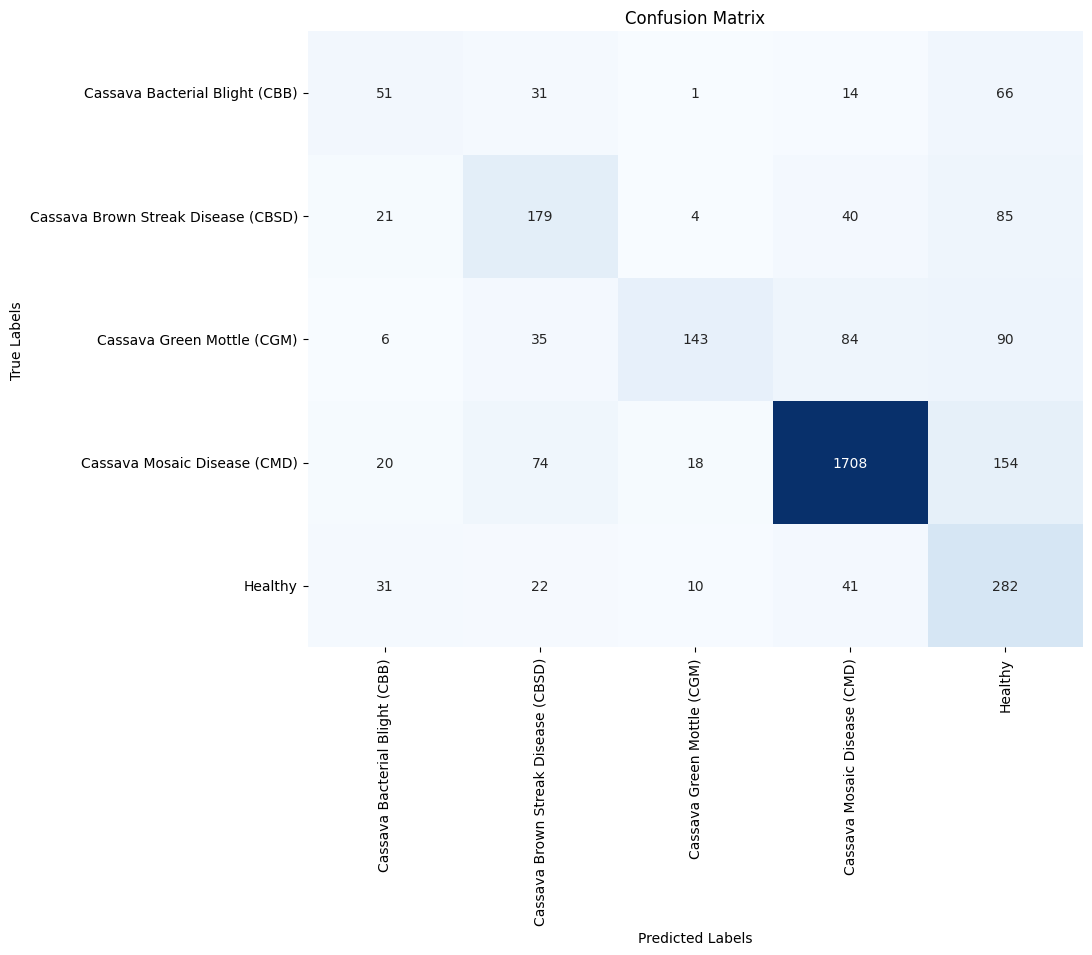

In [17]:
class_names = {
    0: "Cassava Bacterial Blight (CBB)",
    1: "Cassava Brown Streak Disease (CBSD)",
    2: "Cassava Green Mottle (CGM)",
    3: "Cassava Mosaic Disease (CMD)",
    4: "Healthy"
}
y_trues, y_hats = [], []
# Asegúrate de que el modelo esté en modo evaluación
lightningModule_cargado.eval()
for (x, y_true) in iter(data_module.test_dataloader()):

    with torch.no_grad():
        y_hat_logits = lightningModule_cargado(x)
        y_hat = nn.Softmax(1)(y_hat_logits).argmax(1)
        y_hat = y_hat.detach().cpu()

    y_hats.append(y_hat)
    y_trues.append(y_true)

y_trues = torch.cat(y_trues)
y_hats = torch.cat(y_hats)

print(f'Acc.: {accuracy_score(y_trues, y_hats):.4f}')

# Lista de etiquetas para los cálculos (del 0 al 4)
labels_list = torch.arange(5)

# --- 1. F1 SCORE (Macro) ---
# 'macro' calcula la métrica para cada clase y saca la media (sin ponderar)
f1_macro_transf_geo = f1_score(y_trues, y_hats, average='macro', labels=labels_list)
print(f'F1 Score (Macro): {f1_macro_transf_geo:.4f}')

# --- 2. MEDIA GEOMÉTRICA (G-Mean) ---
# Primero, obtenemos el Recall (sensibilidad) para CADA clase por separado
per_class_recall_transf_geo = recall_score(y_trues, y_hats, average=None, labels=labels_list)
print("\nRecall por clase (para G-Mean):")
print(per_class_recall_transf_geo)

# Calculamos la media geométrica: (R1 * R2 * ... * Rn)^(1/n)
# Nota: Si el recall de CUALQUIER clase es 0, la G-Mean será 0.
g_mean_transf_geo = np.prod(per_class_recall_transf_geo)**(1.0 / len(per_class_recall_transf_geo))
print(f'Media Geométrica (G-Mean): {g_mean_transf_geo:.4f}\n')


# --- REPORTE DE CLASIFICACIÓN ---
# Esta función te da Recall, Precision y F1 por clase, todo de una vez.
class_labels = list(class_names.values()) 
print("--- Reporte de Clasificación Detallado ---")
print(classification_report(y_trues, y_hats, target_names=class_labels, labels=labels_list))


# --- Tu código de Matriz de Confusión ---
cm = confusion_matrix(y_trues, y_hats, labels=labels_list)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.savefig("Confusion_matrix_transformaciones geometricas", dpi=400)
plt.show()

### Transforms with Color

In [18]:
photogenic_transforms = transforms.Compose([
    # Resize and crop to standard size
    transforms.Resize(256),
    transforms.CenterCrop(224),
    
    # Color jitter: brightness, contrast, saturation (applied randomly)
    transforms.RandomApply(
        [transforms.ColorJitter(brightness=0.3, contrast=0.4, saturation=0.35)],
        p=0.8
    ),
    
    # Gaussian blur (applied randomly, mild)
    transforms.RandomApply(
        [transforms.GaussianBlur(kernel_size=(3,3), sigma=(0.1, 1.2))],
        p=0.2
    ),
    
    # Sharpen filter (applied randomly)
    transforms.RandomApply(
        [transforms.Lambda(lambda img: img.filter(ImageFilter.SHARPEN))],
        p=0.5
    ),
    
    # Convert to tensor and normalize
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [19]:
# Set random seed for reproducibility
pl.seed_everything(seed=42, workers=True)

data_module = CassavaDataModule(cassava_df, IMAGE_ROOT_DIR)
data_module.setup('fit')

ckpt_path = "/home/alumno/Desktop/datos/Assigment 2/assigment2/best_valid_loss.ckpt"

base_model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

num_in_feat = base_model.fc.in_features
base_model.fc = nn.Linear(num_in_feat, 5)

# Load the best model. Note that we need to include all the LightningMNISTClassifier's __init__ parameters
# model = LightningModule.load_from_checkpoint(ckpt_path, model=model)
lightningModule_cargado = LightningModule.load_from_checkpoint(
    ckpt_path, 
    model=base_model 
)


# Define a CSV logger to store training/validation metrics in CSV format.
csv_logger = CSVLogger(save_dir=os.getcwd(), name="cassava_resnet18_tl_ft_feature_Extractor_Color")

# Define a checkpoint callback:
# It will save the model with the lowest validation loss ("best_valid_loss.ckpt").
model_checkpoint_callback = pl.callbacks.model_checkpoint.ModelCheckpoint(
    monitor='val_loss',mode='min', filename='best_valid_loss', verbose=True, save_last=False)

# Create a PyTorch Lightning trainer
trainer = pl.Trainer(max_epochs=10, logger=csv_logger, callbacks=[model_checkpoint_callback, lr_finder, bs_finder],accelerator='gpu') 
# Load the data module
data_module_trans_color = CassavaDataModule(cassava_df, IMAGE_ROOT_DIR, train_transform = photogenic_transforms)

lightningModule_cargado.train()
# Train the lightningModule_cargado with the trainer, passing the core LightningModule and data module.
trainer.fit(lightningModule_cargado, data_module_trans_color)


Seed set to 42


INFO: No se proporcionó 'train_transform'. Usando transformaciones de validación para train.
Dataset sizes: Train=14977, Val=3210, Test=3210
Train Transforms: Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Val/Test Transforms: Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


INFO: Usando 'train_transform' personalizada para el conjunto de entrenamiento.
Dataset sizes: Train=14977, Val=3210, Test=3210
Train Transforms: Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    RandomApply(
    p=0.8
    ColorJitter(brightness=(0.7, 1.3), contrast=(0.6, 1.4), saturation=(0.65, 1.35), hue=None)
)
    RandomApply(
    p=0.2
    GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 1.2))
)
    RandomApply(
    p=0.5
    Lambda()
)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Val/Test Transforms: Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


Finding best initial lr:   0%|          | 0/30 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=30` reached.
Restoring states from the checkpoint path at /home/alumno/Desktop/datos/Assigment 2/assigment2/.lr_find_05b85801-ccf6-417c-a1e2-8774e0bcbbff.ckpt
Restored all states from the checkpoint at /home/alumno/Desktop/datos/Assigment 2/assigment2/.lr_find_05b85801-ccf6-417c-a1e2-8774e0bcbbff.ckpt


Average training loss for epoch 0: 1.9611


Learning rate set to 5.411695265464637e-05
`Trainer.fit` stopped: `max_steps=2` reached.
Batch size 16 succeeded, trying batch size 32


Average training loss for epoch 0: 1.8881


`Trainer.fit` stopped: `max_steps=2` reached.
Batch size 32 succeeded, trying batch size 64


Average training loss for epoch 0: 1.9012


`Trainer.fit` stopped: `max_steps=2` reached.
Batch size 64 succeeded, trying batch size 128


Average training loss for epoch 0: 0.4672


Finished batch size finder, will continue with full run using batch size 128
Restoring states from the checkpoint path at /home/alumno/Desktop/datos/Assigment 2/assigment2/.scale_batch_size_4fd7ae6f-de25-41a2-acb6-3cbea6457bd9.ckpt
Restored all states from the checkpoint at /home/alumno/Desktop/datos/Assigment 2/assigment2/.scale_batch_size_4fd7ae6f-de25-41a2-acb6-3cbea6457bd9.ckpt

  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | model | ResNet | 11.2 M | train
-----------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.716    Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode
Restored all states from the checkpoint at /home/alumno/Desktop/datos/Assigment 2/assigment2/.scale_batch_size_4fd7ae6f-de25-41a2-acb6-3cbea6457bd9.ckpt


Sanity Checking: |                                                                                            …

Average validation loss for epoch 0: 0.7178


Training: |                                                                                                   …

Validation: |                                                                                                 …

Epoch 0, global step 118: 'val_loss' reached 0.68386 (best 0.68386), saving model to '/home/alumno/Desktop/datos/Assigment 2/assigment2/cassava_resnet18_tl_ft_feature_Extractor_Color/version_4/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 0: 0.6778
Average training loss for epoch 0: 0.8167


Validation: |                                                                                                 …

Epoch 1, global step 236: 'val_loss' was not in top 1


Average validation loss for epoch 1: 0.7082
Average training loss for epoch 1: 0.3744


Validation: |                                                                                                 …

Epoch 2, global step 354: 'val_loss' reached 0.67764 (best 0.67764), saving model to '/home/alumno/Desktop/datos/Assigment 2/assigment2/cassava_resnet18_tl_ft_feature_Extractor_Color/version_4/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 2: 0.6726
Average training loss for epoch 2: 0.2080


Validation: |                                                                                                 …

Epoch 3, global step 472: 'val_loss' was not in top 1


Average validation loss for epoch 3: 0.7246
Average training loss for epoch 3: 0.1206


Validation: |                                                                                                 …

Epoch 4, global step 590: 'val_loss' was not in top 1


Average validation loss for epoch 4: 0.7260
Average training loss for epoch 4: 0.0858


Validation: |                                                                                                 …

Epoch 5, global step 708: 'val_loss' was not in top 1


Average validation loss for epoch 5: 0.7706
Average training loss for epoch 5: 0.0798


Validation: |                                                                                                 …

Epoch 6, global step 826: 'val_loss' was not in top 1


Average validation loss for epoch 6: 0.7880
Average training loss for epoch 6: 0.0577


Validation: |                                                                                                 …

Epoch 7, global step 944: 'val_loss' was not in top 1


Average validation loss for epoch 7: 0.8284
Average training loss for epoch 7: 0.0337


Validation: |                                                                                                 …

Epoch 8, global step 1062: 'val_loss' was not in top 1


Average validation loss for epoch 8: 0.7944
Average training loss for epoch 8: 0.0428


Validation: |                                                                                                 …

Epoch 9, global step 1180: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


Average validation loss for epoch 9: 0.8130
Average training loss for epoch 9: 0.0382


Acc.: 0.8097
F1 Score (Macro): 0.6638

Recall por clase (para G-Mean):
[0.45398773 0.61398176 0.58379888 0.94782168 0.62953368]
Media Geométrica (G-Mean): 0.6273

--- Reporte de Clasificación Detallado ---
                                     precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.51      0.45      0.48       163
Cassava Brown Streak Disease (CBSD)       0.65      0.61      0.63       329
         Cassava Green Mottle (CGM)       0.79      0.58      0.67       358
       Cassava Mosaic Disease (CMD)       0.90      0.95      0.92      1974
                            Healthy       0.60      0.63      0.62       386

                           accuracy                           0.81      3210
                          macro avg       0.69      0.65      0.66      3210
                       weighted avg       0.80      0.81      0.80      3210



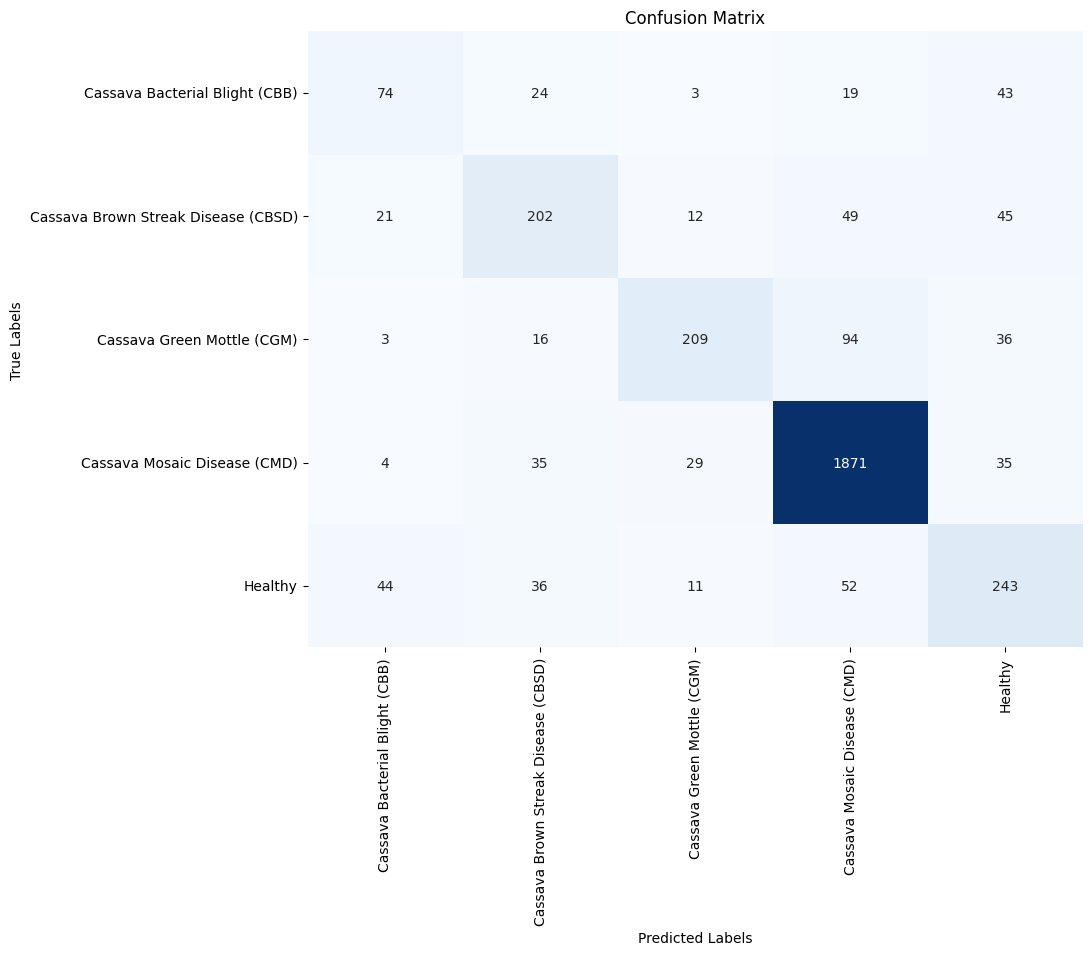

In [21]:
class_names = {
    0: "Cassava Bacterial Blight (CBB)",
    1: "Cassava Brown Streak Disease (CBSD)",
    2: "Cassava Green Mottle (CGM)",
    3: "Cassava Mosaic Disease (CMD)",
    4: "Healthy"
}
y_trues, y_hats = [], []
# Asegúrate de que el modelo esté en modo evaluación
lightningModule_cargado.eval()
for (x, y_true) in iter(data_module.test_dataloader()):

    with torch.no_grad():
        y_hat_logits = lightningModule_cargado(x)
        y_hat = nn.Softmax(1)(y_hat_logits).argmax(1)
        y_hat = y_hat.detach().cpu()

    y_hats.append(y_hat)
    y_trues.append(y_true)

y_trues = torch.cat(y_trues)
y_hats = torch.cat(y_hats)

print(f'Acc.: {accuracy_score(y_trues, y_hats):.4f}')

# Lista de etiquetas para los cálculos (del 0 al 4)
labels_list = torch.arange(5)

# --- 1. F1 SCORE (Macro) ---
# 'macro' calcula la métrica para cada clase y saca la media (sin ponderar)
f1_macro_transf_color = f1_score(y_trues, y_hats, average='macro', labels=labels_list)
print(f'F1 Score (Macro): {f1_macro_transf_color:.4f}')

# --- 2. MEDIA GEOMÉTRICA (G-Mean) ---
# Primero, obtenemos el Recall (sensibilidad) para CADA clase por separado
per_class_recall_transf_color = recall_score(y_trues, y_hats, average=None, labels=labels_list)
print("\nRecall por clase (para G-Mean):")
print(per_class_recall_transf_color)

# Calculamos la media geométrica: (R1 * R2 * ... * Rn)^(1/n)
# Nota: Si el recall de CUALQUIER clase es 0, la G-Mean será 0.
g_mean_transf_color = np.prod(per_class_recall_transf_color)**(1.0 / len(per_class_recall_transf_color))
print(f'Media Geométrica (G-Mean): {g_mean_transf_color:.4f}\n')


# --- REPORTE DE CLASIFICACIÓN ---
# Esta función te da Recall, Precision y F1 por clase, todo de una vez.
class_labels = list(class_names.values()) 
print("--- Reporte de Clasificación Detallado ---")
print(classification_report(y_trues, y_hats, target_names=class_labels, labels=labels_list))


# --- Tu código de Matriz de Confusión ---
cm = confusion_matrix(y_trues, y_hats, labels=labels_list)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.savefig("Confusion_matrix_transformaciones color", dpi=400)
plt.show()

## <span style="color:#D52B29">Advanced / Mixing-based Methods</span>

Aplicamos MixUp a al dataset con transformaciones geométricas

In [22]:
from torchvision.transforms import v2 as transforms_v2

In [23]:
BATCH_SIZE = 128 # Parametro encontrado para mejor batch size en las dos pruebas anteriores
NUM_CLASSES = 5
NUM_WORKERS = 4
mixup = transforms_v2.MixUp(num_classes=NUM_CLASSES, alpha=0.2)
# Set random seed for reproducibility
pl.seed_everything(seed=42, workers=True)

def collate_fn_with_mixup(batch):
    # 1. Deja que PyTorch apile las imágenes y etiquetas en un batch estándar
    # (batch_de_imagenes, batch_de_etiquetas)
    collated_batch = torch.utils.data.default_collate(batch)
    
    # 2. Aplica MixUp al batch completo.
    return mixup(*collated_batch)

print("MixUp y collate_fn definidos.")

Seed set to 42


MixUp y collate_fn definidos.


La siguiente celda la usamos para no tener que ejecutar los anteriores modelos si queremos hacer pruebas con este unicamente

In [24]:
data_module_trans_geo.setup('fit')
base_model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

num_in_feat = base_model.fc.in_features
base_model.fc = nn.Linear(num_in_feat, 5)

lightningModule_MixUp_conGeo = LightningModule.load_from_checkpoint(
    ckpt_path, 
    model=base_model 
)

Dataset sizes: Train=14977, Val=3210, Test=3210
Train Transforms: Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    RandomHorizontalFlip(p=0.4)
    RandomVerticalFlip(p=0.4)
    RandomRotation(degrees=[90.0, 90.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Val/Test Transforms: Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [25]:
train_ds = data_module_trans_geo.train_ds 
labels = train_ds.df['label'].values
class_sample_count = np.array([len(np.where(labels == t)[0]) for t in np.unique(labels)])
weights = 1. / class_sample_count
samples_weight = np.array([weights[t] for t in labels])

sampler = WeightedRandomSampler(
    weights=torch.DoubleTensor(samples_weight),
    num_samples=len(samples_weight),
    replacement=True
)
print("Sampler creado.")

Sampler creado.


In [26]:
# 2.2. Crear el DataLoader de ENTRENAMIENTO (con MixUp)
train_loader_combined = DataLoader(
    data_module_trans_geo.train_ds, # Ya tiene las transformaciones geométricas
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn_with_mixup,     # MixUp (en el batch)
    sampler=sampler,                      # Nivel 0: Weighted Sampler (para balanceo)
    shuffle=False,                        # Incompatible con 'sampler'
    pin_memory=True
)
# 2.3. Crear el DataLoader de VALIDACIÓN (SIN MixUp)
# Nunca aplicamos MixUp ni augmentations al conjunto de validación.
val_loader = DataLoader(
    data_module_trans_geo.val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

#Paso 3 Creamos un nuevo trainer
trainer_nuevo = pl.Trainer(
    max_epochs=10, 
    logger=csv_logger, # Reutilizamos el logger que ya tenías
    callbacks=[model_checkpoint_callback], # Reutilizamos el checkpoint (Quitamos el Lr finder y el batch finder porque ya no nos hacen falta)
    accelerator='gpu'
)

# --- 7. Entrenar el Modelo con el NUEVO trainer ---
print("Iniciando trainer.fit()...")
trainer_nuevo.fit(  
    lightningModule_MixUp_conGeo, 
    train_dataloaders=train_loader_combined,
    val_dataloaders=val_loader
)
print("--- Entrenamiento de Celda completado ---")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/alumno/py313ml/.venv/lib/python3.13/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:751: Checkpoint directory /home/alumno/Desktop/datos/Assigment 2/assigment2/cassava_resnet18_tl_ft_feature_Extractor_Color/version_4/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | model | ResNet | 11.2 M | train
-----------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.716    Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Iniciando trainer.fit()...


Sanity Checking: |                                                                                            …

Average validation loss for epoch 0: 0.7178


Training: |                                                                                                   …

Validation: |                                                                                                 …

Epoch 0, global step 118: 'val_loss' was not in top 1


Average validation loss for epoch 0: 1.0965
Average training loss for epoch 0: 1.2428


Validation: |                                                                                                 …

Epoch 1, global step 236: 'val_loss' was not in top 1


Average validation loss for epoch 1: 1.8715
Average training loss for epoch 1: 0.9651


Validation: |                                                                                                 …

Average validation loss for epoch 2: 1.1599
Average training loss for epoch 2: 0.8996


Validation: |                                                                                                 …

Epoch 3, global step 472: 'val_loss' was not in top 1


Average validation loss for epoch 3: 1.7262
Average training loss for epoch 3: 0.8691


Validation: |                                                                                                 …

Epoch 4, global step 590: 'val_loss' was not in top 1


Average validation loss for epoch 4: 1.7852
Average training loss for epoch 4: 0.8387


Validation: |                                                                                                 …

Epoch 5, global step 708: 'val_loss' was not in top 1


Average validation loss for epoch 5: 0.9992
Average training loss for epoch 5: 0.7870


Validation: |                                                                                                 …

Epoch 6, global step 826: 'val_loss' was not in top 1


Average validation loss for epoch 6: 0.8873
Average training loss for epoch 6: 0.7584


Validation: |                                                                                                 …

Epoch 7, global step 944: 'val_loss' was not in top 1


Average validation loss for epoch 7: 1.8457
Average training loss for epoch 7: 0.7102


Validation: |                                                                                                 …

Epoch 8, global step 1062: 'val_loss' was not in top 1


Average validation loss for epoch 8: 1.5816
Average training loss for epoch 8: 0.6981


Validation: |                                                                                                 …

Epoch 9, global step 1180: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


Average validation loss for epoch 9: 2.2159
Average training loss for epoch 9: 0.6982
--- Entrenamiento de Celda completado ---


Iniciando evaluación en el conjunto de Test (modelo Color+MixUp)...
¡Evaluación completada!
------------------------------
Acc.: 0.2819
F1 Score (Macro): 0.3423

Recall por clase (para G-Mean):
[0.42331288 0.86018237 0.31564246 0.15704154 0.33678756]
Media Geométrica (G-Mean): 0.3604

--- Reporte de Clasificación Detallado (Geometrica + MixUp) ---
                                     precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.30      0.42      0.35       163
Cassava Brown Streak Disease (CBSD)       0.12      0.86      0.22       329
         Cassava Green Mottle (CGM)       0.74      0.32      0.44       358
       Cassava Mosaic Disease (CMD)       0.96      0.16      0.27      1974
                            Healthy       0.60      0.34      0.43       386

                           accuracy                           0.28      3210
                          macro avg       0.55      0.42      0.34      3210
                       weighted 

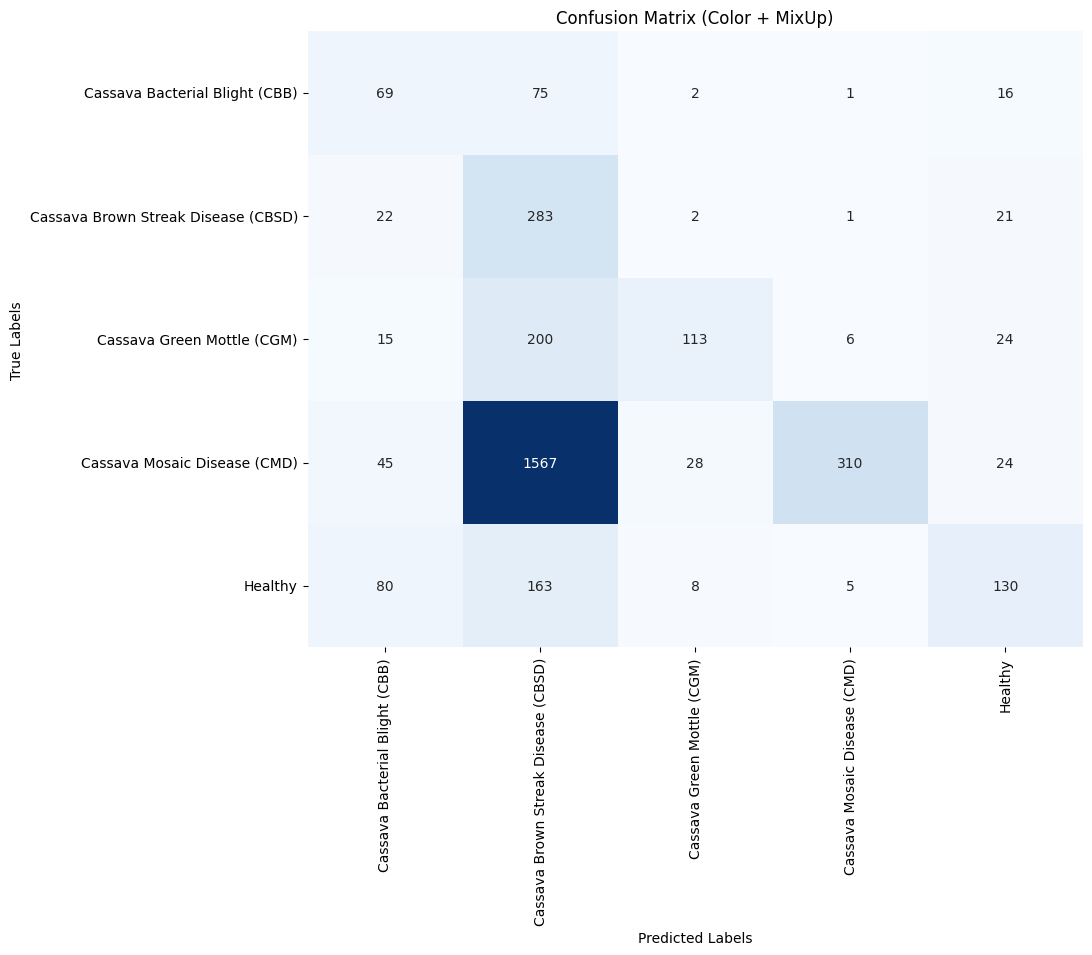

In [28]:
#  Tu diccionario de clases 
class_names = {
    0: "Cassava Bacterial Blight (CBB)",
    1: "Cassava Brown Streak Disease (CBSD)",
    2: "Cassava Green Mottle (CGM)",
    3: "Cassava Mosaic Disease (CMD)",
    4: "Healthy"
}

# --- Bucle de Evaluación ---
y_trues, y_hats = [], []

# 1. Usamos el modelo que acabamos de entrenar (Color+MixUp)
lightningModule_MixUp_conGeo.eval()

# 2. Usamos el dataloader de TEST del data_module de COLOR
test_loader = data_module_trans_geo.test_dataloader() 

# Mover el modelo a la GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lightningModule_MixUp_conGeo.to(device)

print("Iniciando evaluación en el conjunto de Test (modelo Color+MixUp)...")
for (x, y_true) in iter(test_loader):
    # Mover los datos a la GPU
    x = x.to(device)
    
    with torch.no_grad():
        y_hat_logits = lightningModule_MixUp_conGeo(x)
        y_hat = y_hat_logits.argmax(1)
        y_hat = y_hat.cpu() 

    y_hats.append(y_hat)
    y_trues.append(y_true) 

y_trues = torch.cat(y_trues)
y_hats = torch.cat(y_hats)

print("¡Evaluación completada!")
print("-" * 30)

# --- Cálculo de Métricas ---

print(f'Acc.: {accuracy_score(y_trues, y_hats):.4f}')

labels_list = list(class_names.keys()) # [0, 1, 2, 3, 4]

# --- 1. F1 SCORE (Macro) ---
f1_macro_transf_geo_y_MixUp = f1_score(y_trues, y_hats, average='macro', labels=labels_list)
print(f'F1 Score (Macro): {f1_macro_transf_geo_y_MixUp:.4f}')

# --- 2. MEDIA GEOMÉTRICA (G-Mean) ---
per_class_recall_transf_geo_y_MixUp = recall_score(y_trues, y_hats, average=None, labels=labels_list)
print("\nRecall por clase (para G-Mean):")
print(per_class_recall_transf_geo_y_MixUp)

g_mean_transf_geo_y_MixUp = np.prod(per_class_recall_transf_geo_y_MixUp)**(1.0 / len(per_class_recall_transf_geo_y_MixUp))
print(f'Media Geométrica (G-Mean): {g_mean_transf_geo_y_MixUp:.4f}\n')

# --- REPORTE DE CLASIFICACIÓN ---
class_labels = list(class_names.values()) 
print("--- Reporte de Clasificación Detallado (Geometrica + MixUp) ---")
print(classification_report(y_trues, y_hats, target_names=class_labels, labels=labels_list))

# --- Matriz de Confusión ---
cm = confusion_matrix(y_trues, y_hats, labels=labels_list)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix (Color + MixUp)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.savefig("Confusion_matrix_transformaciones_MixUP y Geometrica", dpi=400)
plt.show()

### MIX UP + COLOR

Se reutiliza las variables del número de workers, batch_size, NUM_CLASSES. Además de la definición de la variable mixup y la función collate_fn_with_mixup

In [29]:
data_module_trans_color.setup('fit')

Dataset sizes: Train=14977, Val=3210, Test=3210
Train Transforms: Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    RandomApply(
    p=0.8
    ColorJitter(brightness=(0.7, 1.3), contrast=(0.6, 1.4), saturation=(0.65, 1.35), hue=None)
)
    RandomApply(
    p=0.2
    GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 1.2))
)
    RandomApply(
    p=0.5
    Lambda()
)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Val/Test Transforms: Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [30]:
base_model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

num_in_feat = base_model.fc.in_features
base_model.fc = nn.Linear(num_in_feat, 5)

lightningModule_MixUp_conColor = LightningModule.load_from_checkpoint(
    ckpt_path, 
    model=base_model 
)

In [31]:
train_ds = data_module_trans_color.train_ds 
labels = train_ds.df['label'].values
class_sample_count_color = np.array([len(np.where(labels == t)[0]) for t in np.unique(labels)])
weights_color = 1. / class_sample_count_color
samples_weight_col = np.array([weights_color[t] for t in labels])

sampler = WeightedRandomSampler(
    weights=torch.DoubleTensor(samples_weight_col),
    num_samples=len(samples_weight_col),
    replacement=True
)
print("Sampler creado para las transformaciones de color de la imagen.")

Sampler creado para las transformaciones de color de la imagen.


In [32]:
# 2.2. Crear el DataLoader de ENTRENAMIENTO (con MixUp)
train_loader_combined_color = DataLoader(
    data_module_trans_color.train_ds, # Ya tiene las transformaciones geométricas
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn_with_mixup,     # MixUp (en el batch)
    sampler=sampler,                      # Nivel 0: Weighted Sampler (para balanceo)
    shuffle=False,                        # Incompatible con 'sampler'
    pin_memory=True
)
# 2.3. Crear el DataLoader de VALIDACIÓN (SIN MixUp)
# Nunca aplicamos MixUp ni augmentations al conjunto de validación.
val_loader_color = DataLoader(
    data_module_trans_color.val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

#Reutilizamos el trainer creado antes 

#  3. Entrenar el Modelo con el trainer 
print("Iniciando trainer.fit()...")
trainer_nuevo.fit(  
    lightningModule_MixUp_conColor, 
    train_dataloaders=train_loader_combined_color,
    val_dataloaders=val_loader_color
)
print("--- Entrenamiento de Celda completado ---")

/home/alumno/py313ml/.venv/lib/python3.13/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:751: Checkpoint directory /home/alumno/Desktop/datos/Assigment 2/assigment2/cassava_resnet18_tl_ft_feature_Extractor_Color/version_4/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | model | ResNet | 11.2 M | train
-----------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.716    Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Iniciando trainer.fit()...


Sanity Checking: |                                                                                            …

Average validation loss for epoch 10: 0.7178


`Trainer.fit` stopped: `max_epochs=10` reached.


--- Entrenamiento de Celda completado ---


Iniciando evaluación en el conjunto de Test (modelo Color+MixUp)...
¡Evaluación completada!
------------------------------
Acc.: 0.7417
F1 Score (Macro): 0.5365

Recall por clase (para G-Mean):
[0.25153374 0.47416413 0.32960894 0.94174265 0.53626943]
Media Geométrica (G-Mean): 0.4566

--- Reporte de Clasificación Detallado (Color + MixUp) ---
                                     precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.47      0.25      0.33       163
Cassava Brown Streak Disease (CBSD)       0.52      0.47      0.50       329
         Cassava Green Mottle (CGM)       0.67      0.33      0.44       358
       Cassava Mosaic Disease (CMD)       0.82      0.94      0.88      1974
                            Healthy       0.54      0.54      0.54       386

                           accuracy                           0.74      3210
                          macro avg       0.60      0.51      0.54      3210
                       weighted avg  

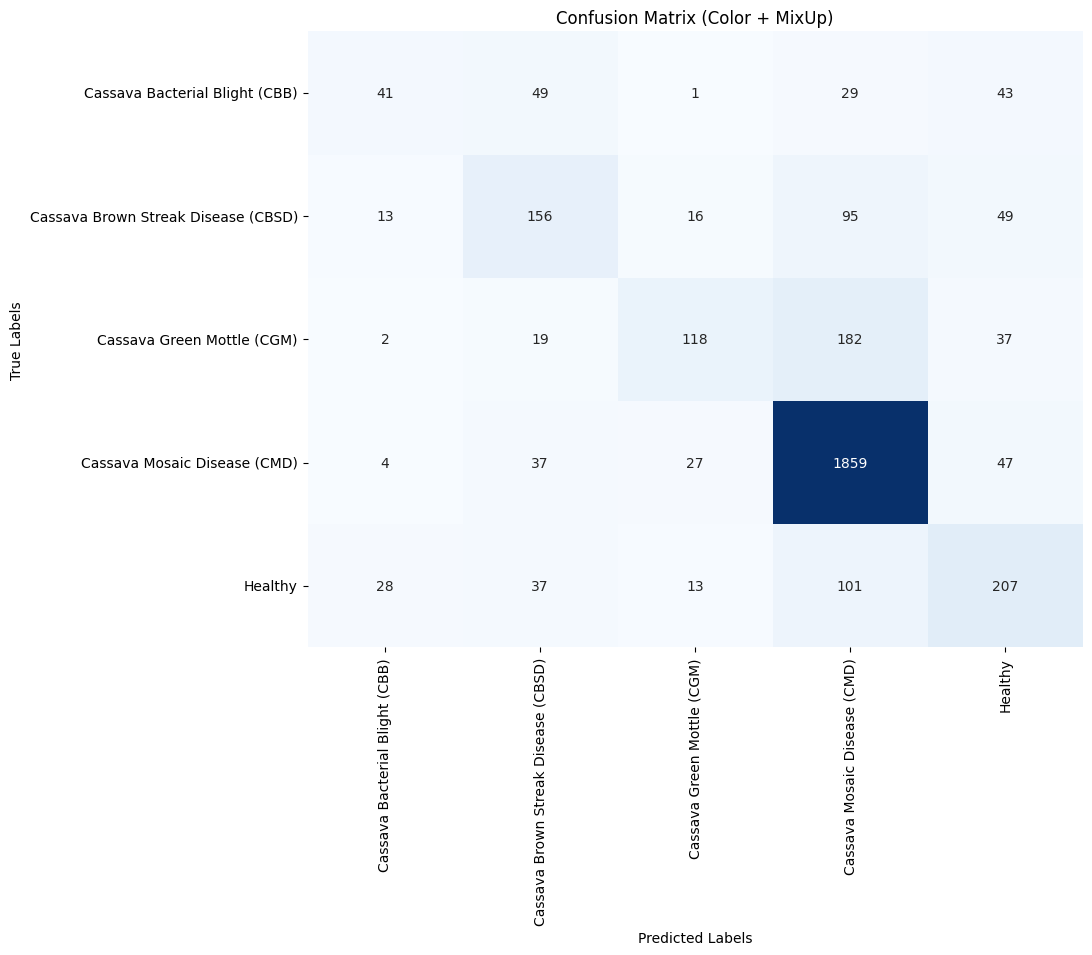

In [33]:
#  Tu diccionario de clases 
class_names = {
    0: "Cassava Bacterial Blight (CBB)",
    1: "Cassava Brown Streak Disease (CBSD)",
    2: "Cassava Green Mottle (CGM)",
    3: "Cassava Mosaic Disease (CMD)",
    4: "Healthy"
}

# --- Bucle de Evaluación ---
y_trues, y_hats = [], []

# 1. Usamos el modelo que acabamos de entrenar (Color+MixUp)
lightningModule_MixUp_conColor.eval()

# 2. Usamos el dataloader de TEST del data_module de COLOR
test_loader = data_module_trans_color.test_dataloader() 

# Mover el modelo a la GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lightningModule_MixUp_conColor.to(device)

print("Iniciando evaluación en el conjunto de Test (modelo Color+MixUp)...")
for (x, y_true) in iter(test_loader):
    # Mover los datos a la GPU
    x = x.to(device)
    
    with torch.no_grad():
        y_hat_logits = lightningModule_MixUp_conColor(x)
        y_hat = y_hat_logits.argmax(1)
        y_hat = y_hat.cpu() 

    y_hats.append(y_hat)
    y_trues.append(y_true) 

y_trues = torch.cat(y_trues)
y_hats = torch.cat(y_hats)

print("¡Evaluación completada!")
print("-" * 30)

# --- Cálculo de Métricas ---

print(f'Acc.: {accuracy_score(y_trues, y_hats):.4f}')

labels_list = list(class_names.keys()) # [0, 1, 2, 3, 4]

# --- 1. F1 SCORE (Macro) ---
f1_macro_transf_color_y_MixUp = f1_score(y_trues, y_hats, average='macro', labels=labels_list)
print(f'F1 Score (Macro): {f1_macro_transf_color_y_MixUp:.4f}')

# --- 2. MEDIA GEOMÉTRICA (G-Mean) ---
per_class_recall_transf_color_y_MixUp = recall_score(y_trues, y_hats, average=None, labels=labels_list)
print("\nRecall por clase (para G-Mean):")
print(per_class_recall_transf_color_y_MixUp)

g_mean_transf_color_y_MixUp = np.prod(per_class_recall_transf_color_y_MixUp)**(1.0 / len(per_class_recall_transf_color_y_MixUp))
print(f'Media Geométrica (G-Mean): {g_mean_transf_color_y_MixUp:.4f}\n')

# --- REPORTE DE CLASIFICACIÓN ---
class_labels = list(class_names.values()) 
print("--- Reporte de Clasificación Detallado (Color + MixUp) ---")
print(classification_report(y_trues, y_hats, target_names=class_labels, labels=labels_list))

# --- Matriz de Confusión ---
cm = confusion_matrix(y_trues, y_hats, labels=labels_list)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix (Color + MixUp)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.savefig("Confusion_matrix_transformaciones_MixUP y color", dpi=400)
plt.show()

In [ ]:
def plot_model_comparison(model_names, metric_values, metric_name="F1 - Score", path_saving = None):
    """
    Crea un gráfico de barras comparativo usando Seaborn.

    Args:
        model_names (list): Lista de strings para las etiquetas del eje X.
        metric_values (list): Lista de valores numéricos para el eje Y.
        metric_name (str): El nombre de la métrica (para la etiqueta del eje Y).
    """
    
    # 1. Crear un DataFrame de Pandas con los datos
    # Seaborn funciona mejor con DataFrames
    data = {
        "Model": model_names,
        metric_name: metric_values
    }
    df = pd.DataFrame(data)
    
    # 2. (Opcional pero recomendado) Ordenar las barras para mejor visualización
    df = df.sort_values(by=metric_name, ascending=False)
    
    # 3. Configurar el gráfico
    plt.figure(figsize=(10, 6)) # Tamaño de la figura
    
    # 4. Crear el gráfico de barras
    ax = sns.barplot(
        x="Model", 
        y=metric_name, 
        data=df,
        palette="Blues_d"
    )

    for container in ax.containers:
        ax.bar_label(container, fmt='%.4f', fontsize=10, padding=3)
    
    # 5. Añadir etiquetas y título
    plt.title(f'Comparación de Modelos por {metric_name}', fontsize=16)
    plt.xlabel('Tipo de Transformación / Modelo', fontsize=12)
    plt.ylabel(metric_name, fontsize=12)
    
    # 6. (Clave) Rotar las etiquetas del eje X para que no se solapen
    plt.xticks(rotation=30, ha='right') # Rotación de 30 grados
    
    # 7. Ajustar el límite Y (asumiendo que es una métrica de 0 a 1)
    if max(metric_values) <= 1.0:
        plt.ylim(0, 1.05)
        
    # Añadir una rejilla
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Ajustar el layout para que entre todo
    plt.tight_layout()

    if path_saving is not None:
        plt.savefig(path_saving, dpi=400, bbox_inches='tight')
        print(f"Gráfico guardado en: {path_saving}")

    # 8. Mostrar el gráfico
    plt.show()

# -----------------------------------------------------------------
# EJEMPLO DE CÓMO USAR LA FUNCIÓN
# -----------------------------------------------------------------

# 1. Tus etiquetas
prediction_names = [
    "No transformation", 
    "Geometric Transform", 
    "Color Transform", 
    "Geometric + MixUp", 
    "Color + MixUp"
]

#Metricas de F1-Score obtenidas en los experimentos
metricas_f1 = [f1_macro_data_no_transf, f1_macro_transf_geo, f1_macro_transf_color, f1_macro_transf_geo_y_MixUp, f1_macro_transf_color_y_MixUp] 
path_for_f1 = "comparacion_modelos_f1_macro.png"
# 3. Llama a la función
plot_model_comparison(prediction_names, metricas_f1, metric_name="F1-Score Macro", path_saving= path_for_f1)

In [ ]:
#Metricas de F1-Score obtenidas en los experimentos
metricas_gmean = [g_mean_no_transf, g_mean_transf_geo, g_mean_transf_color, g_mean_transf_geo_y_MixUp, g_mean_transf_color_y_MixUp]
per_class_recall_transf_geo

path_for_gmean = "comparacion_modelos_gmean.png"
# 3. Llama a la función
plot_model_comparison(prediction_names, metricas_gmean, metric_name="G-mean")
# path_saving= path_for_gmean
# per_class_recall_transf_color_y_MixUp




# per_class_recall_transf_geo_y_MixUp
